In [11]:
import os
import h5py
import numpy as np
import mne
import os
import re
from sklearn.discriminant_analysis import StandardScaler

task_labels = {
    'rest': 0,
    'task_working_memory': 1,
    'task_motor': 2,
    'task_story_math': 3
}

# Run this block if you want to preprocess all the files in the dataset.
def extract_dataset_name(file_path):
    # file path by '\' (Windows)
    components = file_path.split(os.sep)
    
    # Get the filename from the path
    filename = components[-1]
    
    # Use regular expression to find the specific patterns
    match = re.search(r'(rest|task_working_memory|task_motor|task_story_math)_\d+', filename)
    
    if match:
        dataset_name = match.group(0)
        return dataset_name
    
    return None  # Return None if the pattern is not found

def extract_task_name(file_path):
    
    match = re.search(r'(rest|task_working_memory|task_motor|task_story_math)_\d+', file_path)
    print(match.group(1))
    if match:
        return match.group(1)
    
    return None

def preprocess_MEG_data(root_dir, task):
    output_dir = 'Preprocessed'
    output_dir_scale = 'Preprocessed_scale'
    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith('.h5'):
                file_path = os.path.join(dirpath, filename)
                
                relative_path = os.path.relpath(file_path, root_dir)
                output_path = os.path.join(output_dir, task, relative_path)
                output_dirname = os.path.dirname(output_path)
                os.makedirs(output_dirname, exist_ok=True)
                
                
                npy_output_path = output_path.replace('.h5', '.npz')

                output_path_scale = os.path.join(output_dir_scale, task, relative_path)
                output_dirname_scale = os.path.dirname(output_path_scale)
                os.makedirs(output_dirname_scale, exist_ok=True)
                npy_output_path_scale = output_path_scale.replace('.h5', '.npz')

                # if os.path.exists(npy_output_path) and os.path.exists(npy_output_path_scale):
                #     print(f"Output file {npy_output_path} already exists. Skipping..")
                #     continue  # Move to the next file
                with h5py.File(file_path, 'r') as f:
                    dataset_name = extract_dataset_name(fr'{file_path}')
                    print(dataset_name)
                    data = f.get(dataset_name)[:]
                    
                    channel_names = ['Ch' + str(i + 1) for i in range(data.shape[0])]
                    channel_types = ['mag' for i in range(data.shape[0])]
                    sfreq = 2034
                    info = mne.create_info(ch_names=channel_names, ch_types=channel_types, sfreq=sfreq)
                    raw = mne.io.RawArray(data,info)
                    
                    # Low frequency drifts are reduced with high-pass filtering.
                    raw_highpass = raw.copy().filter(l_freq=0.4, h_freq=None)
                    freqs = (60, 120)
                    # Notch filter to remove power line noise at 60 Hz and 120 Hz.
                    raw_notch = raw_highpass.copy().notch_filter(freqs=freqs)
                    # Low pass filter to reduce frequencies above 333 Hz.
                    raw_notch_lowpass = raw_notch.copy().filter(l_freq=None, h_freq=333)
                    # Resample for computational efficiency # Choice can be explained
                    #raw_downsampled = raw_notch_lowpass.copy().resample(sfreq=1000)
                    # time wise normalisation for each of the 248 channels.
                    scaled_data = mne.decoding.Scaler(info=raw_notch_lowpass.info).fit_transform(raw_notch_lowpass.get_data().reshape((raw_notch_lowpass.get_data().shape[1], raw_notch_lowpass.get_data().shape[0])))
                    
                    # Extract task name from file path
                    current_task = extract_task_name(file_path)
                    label = task_labels[current_task]
                    #Save preprocessed data as numpy array.
                    np.savez(npy_output_path, data=scaled_data, task=current_task, label=label)


                    # Save only scaled data
                    # Z-Score Normalization
                    scaler = StandardScaler()
                    X_standardized = scaler.fit_transform(data.T)
                    np.savez(npy_output_path_scale, data=X_standardized, task=current_task, label=label)





tasks = ['Intra', 'Cross']


root_directories = {
    'Intra': 'data/Intra',
    'Cross': 'data/Cross'
}

# Process files for each task
for task in tasks:
    root_directory = root_directories[task]
    preprocess_MEG_data(root_directory, task)


task_motor_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
rest_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
task_story_math_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
task_working_memory_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
task_motor_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
task_story_math_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
task_working_memory_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
rest_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
rest_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
task_story_math_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
task_motor_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
task_story_math_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
task_story_math_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
task_working_memory_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
task_motor_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
rest_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
rest_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
task_working_memory_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
task_motor_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
rest_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
task_motor_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
task_working_memory_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
task_motor_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
rest_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
rest_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
task_motor_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
task_working_memory_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
task_story_math_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
task_motor_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
task_working_memory_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
task_motor_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
task_working_memory_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
rest_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
rest_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
task_working_memory_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
task_story_math_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
task_story_math_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
task_story_math_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
task_working_memory_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
task_story_math_105923
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
task_story_math_162935
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
rest_162935
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
task_story_math_162935
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
task_story_math_162935
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
rest_162935
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
task_motor_162935
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
rest_162935
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
task_working_memory_162935
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
task_motor_162935
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
task_working_memory_162935
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
task_working_memory_162935
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
rest_162935
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
task_motor_162935
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
task_working_memory_162935
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
task_motor_162935
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
task_story_math_162935
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
task_working_memory_113922
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
task_motor_113922
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
task_story_math_164636
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
rest_164636
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
rest_113922
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
task_working_memory_113922
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
task_motor_113922
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
task_story_math_113922
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
rest_113922
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
task_working_memory_113922
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
task_story_math_164636
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
task_motor_164636
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
task_working_memory_113922
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
task_motor_113922
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
task_story_math_164636
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
rest_113922
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
task_story_math_113922
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
task_motor_164636
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
task_working_memory_164636
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
rest_164636
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
rest_164636
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
task_motor_164636
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
task_story_math_113922
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
task_working_memory_164636
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
task_working_memory_113922
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
rest_164636
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
task_motor_164636
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
task_story_math_113922
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
task_story_math_113922
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
task_motor_164636
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
task_working_memory_164636
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
rest_164636
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
task_story_math_164636
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
rest_164636
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
task_working_memory_164636
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
task_motor_164636
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
rest_113922
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
task_working_memory_164636
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
task_motor_164636
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
task_story_math_113922
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
task_working_memory_164636
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
task_motor_164636
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
task_story_math_113922
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
rest_164636
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
task_motor_113922
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
rest_164636
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
task_working_memory_164636
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
task_story_math_113922
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
rest_113922
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
task_motor_113922
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
task_story_math_164636
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
task_working_memory_113922
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
task_story_math_164636
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
task_motor_113922
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
task_working_memory_113922
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
rest_113922
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
task_story_math_164636
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
task_motor_113922
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
task_working_memory_113922
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
rest_113922
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
rest_113922
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
task_motor_113922
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
task_story_math_164636
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
task_working_memory_164636
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
task_motor_725751
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
task_working_memory_735148
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
rest_735148
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
task_story_math_725751
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
task_story_math_735148
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
task_story_math_735148
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
rest_725751
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
task_motor_725751
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
task_working_memory_725751
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
rest_735148
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
task_motor_735148
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
task_working_memory_735148
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
task_working_memory_725751
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
task_motor_735148
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
rest_725751
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
task_story_math_725751
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
task_motor_707749
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
task_story_math_707749
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
task_motor_707749
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
task_motor_707749
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
task_working_memory_707749
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
rest_707749
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
task_motor_707749
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_motor
task_story_math_707749
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
task_working_memory_707749
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
rest_707749
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
rest_707749
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
rest_707749
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


rest
task_story_math_707749
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
task_story_math_707749
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_story_math
task_working_memory_707749
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory
task_working_memory_707749
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 333.00 Hz
- Upper transition bandwidth: 83.25 Hz (-6 dB cutoff frequency: 374.62 Hz)
- Filter length: 81 samples (0.040 s)



[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


task_working_memory


In [11]:
loaded_data = np.load(r'Preprocessed\Cross\test1\rest_162935_1.npz')

In [14]:
loaded_data['data'].shape

(17514, 248, 1)

In [9]:
import re


extract_task_name(r'task_working_memory_105923_9.h5')

task_working_memory


'task_working_memory'

In [8]:
import numpy as np

# Load the .npy file
loaded_data = np.load(r'Preprocessed\Cross\test1\rest_162935_1.npy')

In [17]:
loaded_data['label'].item()

0

In [14]:
np.max(loaded_data.reshape(loaded_data.shape[1],loaded_data.shape[0]))

6605.345713076805

In [118]:
import numpy as np
import mne
channel_names = ['Ch' + str(i + 1) for i in range(matrix.shape[0])]
channel_types = ['mag' for i in range(matrix.shape[0])]
sfreq = 2034
info = mne.create_info(ch_names=channel_names, ch_types=channel_types, sfreq=sfreq)
raw = mne.io.RawArray(matrix,info)
print(raw.info)
# Low frequency drifts are removed with high-pass filtering.
raw_highpass = raw.copy().filter(l_freq=0.4, h_freq=None)
freqs = (60, 120)
# Notch filter to remove power line noise at 60 Hz and its harmonics.
raw_notch = raw_highpass.copy().notch_filter(freqs=freqs)
print(raw_notch.info)
# Resample for computational efficiency
raw_downsampled = raw_notch.copy().resample(sfreq=800)
# time wise normalisation for each of the 248 channels.
scaled_data = mne.decoding.Scaler(scalings='median').fit_transform(raw_downsampled.get_data().reshape((raw_downsampled.get_data().shape[1], raw_downsampled.get_data().shape[0])))



Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
<Info | 7 non-empty values
 bads: []
 ch_names: Ch1, Ch2, Ch3, Ch4, Ch5, Ch6, Ch7, Ch8, Ch9, Ch10, Ch11, Ch12, ...
 chs: 248 Magnetometers
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 1017.0 Hz
 meas_date: unspecified
 nchan: 248
 projs: []
 sfreq: 2034.0 Hz
>
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.6s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.4s


<Info | 7 non-empty values
 bads: []
 ch_names: Ch1, Ch2, Ch3, Ch4, Ch5, Ch6, Ch7, Ch8, Ch9, Ch10, Ch11, Ch12, ...
 chs: 248 Magnetometers
 custom_ref_applied: False
 highpass: 0.4 Hz
 lowpass: 1017.0 Hz
 meas_date: unspecified
 nchan: 248
 projs: []
 sfreq: 2034.0 Hz
>


In [120]:
scaled_data.reshape((248, 14011)).mean(axis=1)

array([-0.01403867, -0.02275553,  0.00472655, -0.03193126,  0.02612693,
       -0.02553342,  0.00467075, -0.02580585, -0.00452018, -0.0301554 ,
       -0.04296115, -0.00482816, -0.00220291, -0.02020108,  0.00545782,
       -0.01568712,  0.03298113,  0.01048816, -0.04623973,  0.04140294,
       -0.00483714, -0.03902343, -0.03637983, -0.02119511, -0.02467495,
        0.0026101 , -0.03533327,  0.02864648,  0.02973334,  0.02612741,
        0.01684448, -0.02779421, -0.02672377, -0.04330507,  0.03764554,
        0.03024972,  0.04445545,  0.00669903,  0.00542323, -0.01477054,
        0.02353748, -0.05770284,  0.00344356,  0.00638179, -0.03103388,
       -0.03351635, -0.04894265, -0.00555794, -0.01680088, -0.0071744 ,
       -0.02260401, -0.03081611,  0.02754363, -0.11600064,  0.0701948 ,
        0.01136278, -0.02238682, -0.01651752,  0.08406924, -0.04445496,
       -0.06885942, -0.0723935 , -0.0159836 , -0.0295676 ,  0.02879347,
       -0.03723558,  0.03834566,  0.02109006, -0.03632897, -0.03

In [92]:
a = np.array([[1,1,1],
              [2,2,2]])
print(a.shape)
np.mean(a, axis=1)

(2, 3)


array([1., 2.])

In [3]:
print(raw.info)
print('Duration:', raw.times[-1], 'seconds')

<Info | 7 non-empty values
 bads: []
 ch_names: Ch1, Ch2, Ch3, Ch4, Ch5, Ch6, Ch7, Ch8, Ch9, Ch10, Ch11, Ch12, ...
 chs: 248 Magnetometers
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 1017.0 Hz
 meas_date: unspecified
 nchan: 248
 projs: []
 sfreq: 2034.0 Hz
>
Duration: 17.513765978367747 seconds


In [4]:
ssp_projectors = raw.info["projs"]
raw.del_proj()

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,248 Magnetometers
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2034.00 Hz
Highpass,0.00 Hz
Lowpass,1017.00 Hz


In [5]:
print(raw.info["bads"])

[]


Using matplotlib as 2D backend.


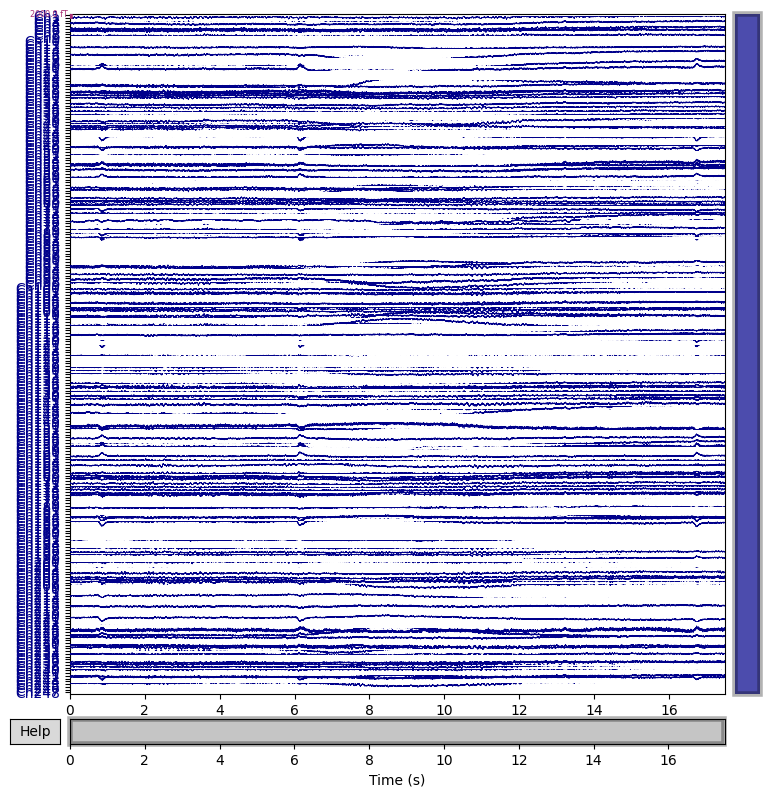

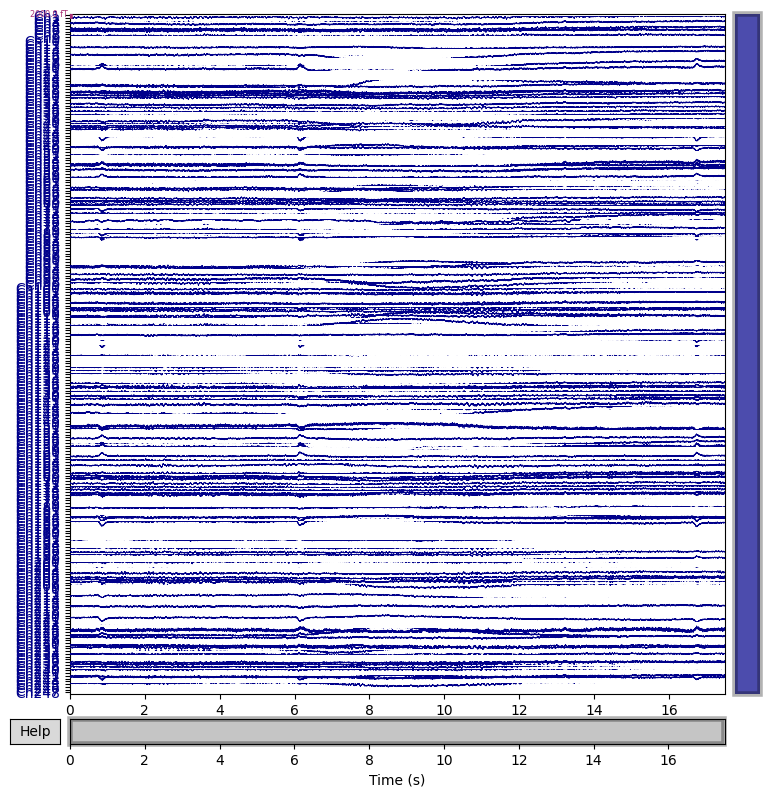

In [6]:
# Slow drifts

raw.plot(duration=17.5, proj=False, n_channels=len(raw.ch_names), remove_dc=False)



Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Filter length: 33561 samples (16.500 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    3.5s


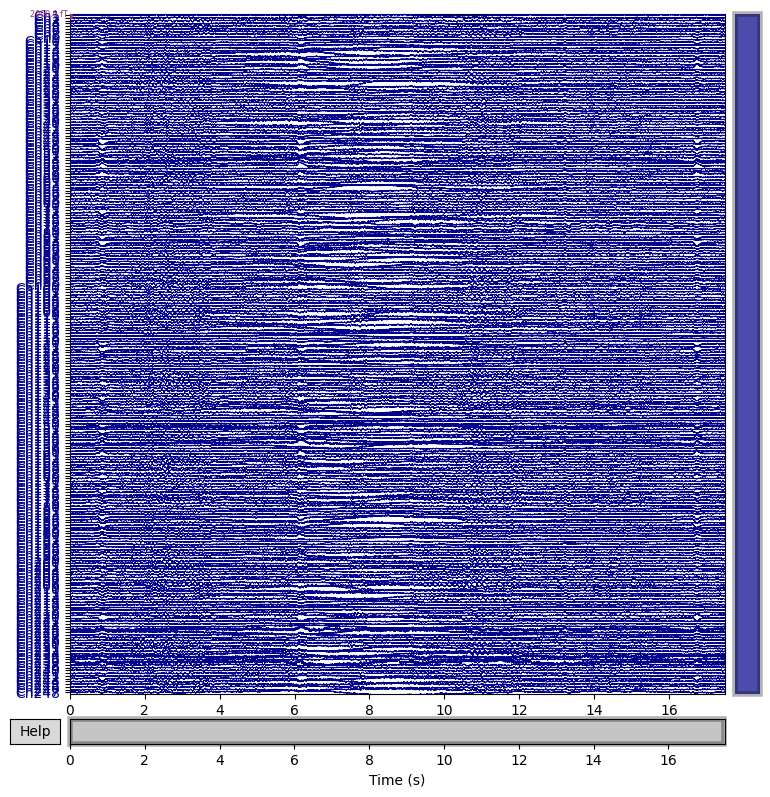

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.8s


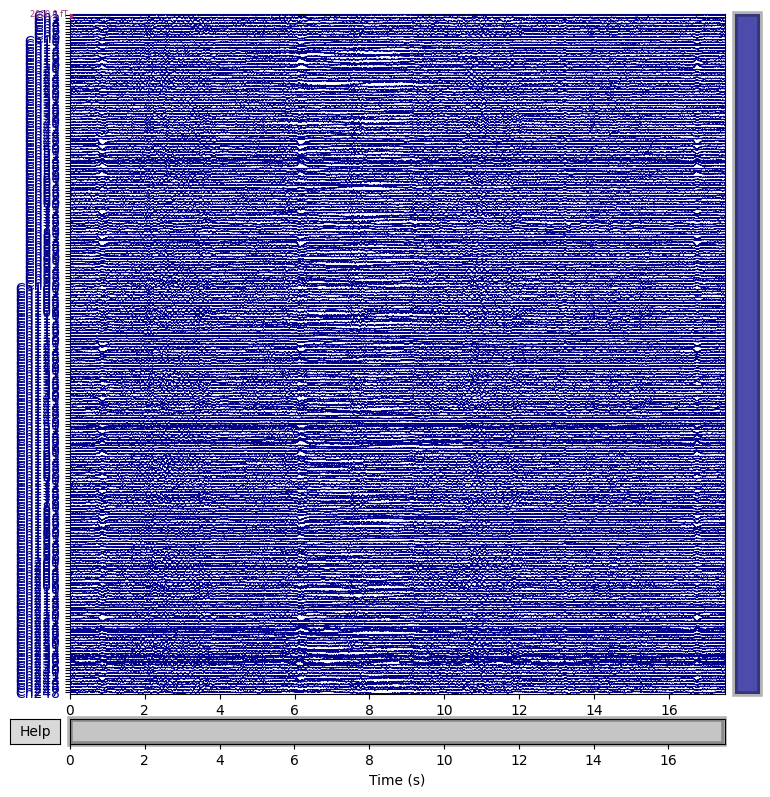

In [7]:
for cutoff in (0.2, 0.4):
    raw_highpass = raw.copy().filter(l_freq=cutoff, h_freq=None)
    with mne.viz.use_browser_backend("matplotlib"):
        fig = raw_highpass.plot(
            duration=17.5, proj=False, n_channels=len(raw.ch_names), remove_dc=False
        )
    fig.subplots_adjust(top=0.9)
    fig.suptitle(
        "High-pass filtered at {} Hz".format(cutoff), size="xx-large", weight="bold"
    )

In [8]:
filter_params = mne.filter.create_filter(
    raw.get_data(), raw.info["sfreq"], l_freq=0.4, h_freq=None
)

Setting up high-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Filter length: 16781 samples (8.250 s)



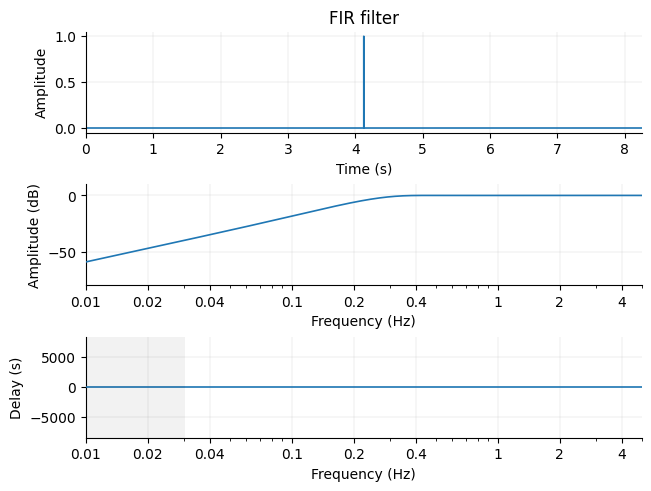

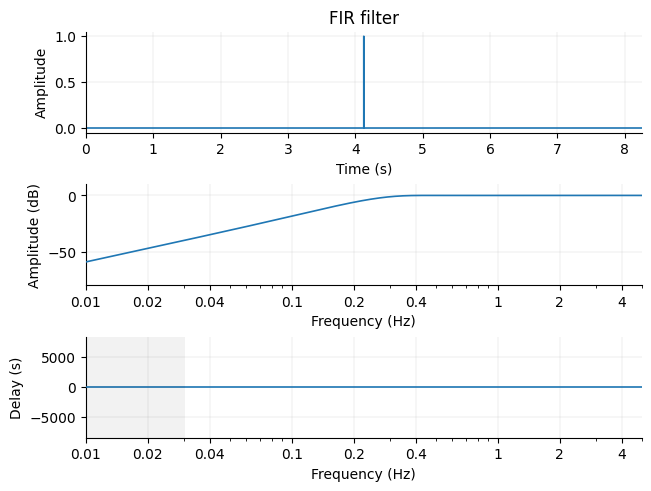

In [9]:
mne.viz.plot_filter(filter_params, raw.info["sfreq"], flim=(0.01, 5))

In [11]:
%matplotlib notebook
# Power line noise environmental artifact that manifests as persistent oscillations centered around the AC power line frequency
fig = raw.compute_psd(tmax=np.inf, fmax=250).plot(
    average=True, picks="data", exclude="bads")
fig.savefig('psd_plot.png')

Effective window size : 1.007 (s)


<IPython.core.display.Javascript object>

In [14]:
meg_picks = mne.pick_types(raw.info, meg=True)
freqs = (60, 120)
raw_notch = raw.copy().notch_filter(freqs=freqs, picks=meg_picks)
for title, data in zip(["Un", "Notch "], [raw, raw_notch]):
    fig = data.compute_psd(fmax=250).plot(average=True, picks="data", exclude="bads")
    fig.suptitle("{}filtered".format(title), size="xx-large", weight="bold")
    fig.savefig('psd_notched_plot.png')

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13425 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.2s


Effective window size : 1.007 (s)


<IPython.core.display.Javascript object>

Effective window size : 1.007 (s)


<IPython.core.display.Javascript object>

In [17]:
raw.get_data()

array([[ 1.97084298e-12,  2.05354267e-12,  2.15993716e-12, ...,
         3.76791523e-12,  3.73353432e-12,  3.84085819e-12],
       [-3.65499341e-12, -3.84306129e-12, -4.03623706e-12, ...,
        -5.83472593e-12, -5.77250097e-12, -5.84865663e-12],
       [ 2.25851130e-12,  2.22853290e-12,  2.31691077e-12, ...,
         3.08775379e-12,  3.10566308e-12,  3.13019098e-12],
       ...,
       [ 2.69611351e-12,  2.78066936e-12,  2.76576960e-12, ...,
         4.65467768e-12,  4.52058052e-12,  4.51164063e-12],
       [-5.07980854e-12, -5.11056778e-12, -5.06082155e-12, ...,
        -6.20575379e-12, -6.26423436e-12, -6.20271586e-12],
       [-6.09371928e-12, -6.22285079e-12, -6.26193498e-12, ...,
        -3.39112787e-12, -3.35855757e-12, -3.36085673e-12]])

In [3]:

import numpy as np
loaded_data = np.load('Preprocessed/Cross/test1/rest_162935_1.npz')

In [19]:
loaded_data["data"].reshape(-1, 248)


array([[ -13.2600478 , -177.5272533 , -180.76237838, ...,  343.40246435,
         302.04335487,  311.39039858],
       [ 506.27550774,  491.38882686,  486.67364923, ...,  815.47714507,
        1184.02413018,  874.17229069],
       [ 486.24075965,  524.73085869,  607.09929965, ...,  117.01808826,
         -17.22710427, -294.02271408],
       ...,
       [ -19.43980143,  104.89711653,   96.42203954, ...,   87.65059059,
         139.73719212,  -11.25613755],
       [ 146.7406692 ,  334.03989603,  155.4902005 , ...,  -67.52361841,
        -149.54749158, -332.61787252],
       [-177.95135841,   69.52255686,  -67.60757255, ..., -123.83026335,
        -164.88541299, -131.25216465]])